In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os
import random
import time

import matplotlib.pyplot as plt

import numpy as np

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
data_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

In [4]:
train_data = datasets.MNIST('data', 
                            train = True, 
                            download = True, 
                            transform = data_transforms)

test_data = datasets.MNIST('data', 
                           train = False, 
                           download = True, 
                           transform = data_transforms)

In [5]:
n_train_examples = int(len(train_data)*0.9)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


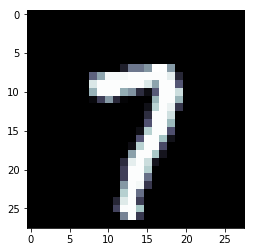

In [7]:
plt.imshow(train_data[0][0].squeeze(0).numpy(), cmap='bone');

In [8]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size = BATCH_SIZE)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, output_dim):
        super().__init__()
        
        assert len(hid_dims) > 0
        
        self.input_fc = nn.Linear(input_dim, hid_dims[0])
        
        self.fcs = nn.ModuleList([nn.Linear(hid_dims[i], hid_dims[i+1]) 
                                  for i in range(len(hid_dims)-1)])
        
        self.output_fc = nn.Linear(hid_dims[-1], output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        x = x.view(x.shape[0], -1)
        
        #x = [batch size, height * width]
        
        x = F.relu(self.input_fc(x))
        
        #x = [batch size, hid dims[0]]
        
        for fc in self.fcs:
            x = F.relu(fc(x))
        
        #x = [batch size, hid dims[-1]]
        
        x = self.output_fc(x)
        
        #x = [batch size, output dim]
        
        return x

In [10]:
INPUT_DIM = 28 * 28
HID_DIMS = [1000, 500, 250]
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, HID_DIMS, OUTPUT_DIM)

In [11]:
model

MLP(
  (input_fc): Linear(in_features=784, out_features=1000, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
  )
  (output_fc): Linear(in_features=250, out_features=10, bias=True)
)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,413,260 trainable parameters


In [13]:
optimizer = optim.Adam(model.parameters())

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model = model.to(device)
criterion = criterion.to(device)

In [17]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.221 | Train Acc: 93.16%
	 Val. Loss: 0.158 |  Val. Acc: 95.15%
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 0.098 | Train Acc: 97.06%
	 Val. Loss: 0.109 |  Val. Acc: 96.84%
Epoch: 03 | Epoch Time: 0m 13s
	Train Loss: 0.070 | Train Acc: 97.85%
	 Val. Loss: 0.112 |  Val. Acc: 96.57%
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 0.054 | Train Acc: 98.31%
	 Val. Loss: 0.091 |  Val. Acc: 97.50%
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.046 | Train Acc: 98.62%
	 Val. Loss: 0.091 |  Val. Acc: 97.59%
Epoch: 06 | Epoch Time: 0m 13s
	Train Loss: 0.040 | Train Acc: 98.80%
	 Val. Loss: 0.104 |  Val. Acc: 97.32%
Epoch: 07 | Epoch Time: 0m 13s
	Train Loss: 0.034 | Train Acc: 98.99%
	 Val. Loss: 0.122 |  Val. Acc: 97.22%
Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 0.029 | Train Acc: 99.12%
	 Val. Loss: 0.077 |  Val. Acc: 98.27%
Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 0.025 | Train Acc: 99.19%
	 Val. Loss: 0.105 |  Val. Acc: 97.70%
Epoch: 10 | Epoch T

In [22]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.072 | Test Acc: 98.45%
